# ResNet 50 All In One

In [1]:
import numpy as np
import os
from matplotlib import pyplot as plt
import cv2
import csv
import pandas as pd
import glob
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential, Model, load_model
from keras.layers import Conv2D #images are two dimensional. Videos are three dimension.
from keras.layers import MaxPooling2D, Flatten, Dense, Dropout

from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator

In [2]:
from keras.applications.resnet import ResNet50
from keras.applications.resnet import preprocess_input

In [3]:
from keras.optimizers import Adam
from datetime import datetime
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

In [4]:
from auto_label import auto_label, PRECISION_SOLO

In [5]:
def auto_label_last_201(seg_model, seg_nd, cluster_num, mode, threshold=0.5):
    # cluster_num: the total number of clusters
    assert mode in [1,2,3,4], "Invalid mode: mode should be integer in [1,2,3,4]."
    if mode == 1:
        assert threshold == 0.5, "Mode 1 requires threshold = 0.5."

    csv_file = os.path.join(os.getcwd(), 'seg_res_evaluation_csv', '{}_{}_{}.csv'.format(seg_model, seg_nd, cluster_num))
    #df = pd.read_csv(csv_file, usecols=['slice', 'current_cluster','pore_micro_precision', 'pore_micro_f1', 'gypsum_micro_precision', 'gypsum_micro_f1', 'celestite_micro_precision', 'celestite_micro_f1', 'bassanite_micro_precision', 'bassanite_micro_f1'])
    df = pd.read_csv(csv_file, usecols=['slice', 'current_cluster','pore_precision', 'pore_f1', 'gypsum_precision', 'gypsum_f1', 'celestite_precision', 'celestite_f1', 'bassanite_precision', 'bassanite_f1'])
    df =  df.loc[df['slice'] >= 600]  # only use training set

    label = [0]*cluster_num

    for i in range(cluster_num):
        one_cluster = df.loc[df['current_cluster'] == i]
        stats = one_cluster.mean()
        precisions = [stats[2], stats[4], stats[6], stats[8]]
        fscores = [stats[3], stats[5], stats[7], stats[9]]
        p_max = max(precisions)
        p_idx = np.argmax(precisions)
        f_idx = np.argmax(fscores)
        if mode in [1,2]:
            if p_max <= threshold:
                idx = f_idx
            else:
                idx = p_idx
        elif mode == 3:
            idx = f_idx
        else:
            idx = p_idx
            
        class_num = idx + 1
        label[i] = class_num

    return label

# Data Preprocessing

In [6]:
def get_cluster_num_str(c):
    c = str(c).zfill(3)
    return c

In [7]:
# Set the target segmentation results 
res_folder = 'new_large_clusters_rec'
seg_model = 'k-means'   # choose between 'gmm' and 'k-means'
seg_nd = '3d'   # choose between '3d' and '4d'
cluster_num = 16  # choose between 16, 32, 64, and 128

### Prepare Dataframe for Data Generator

In [8]:
# corresponding csv file to get slice & cluster combination
csv_file = os.path.join(os.getcwd(), 'seg_res_evaluation_csv', '{}_{}_{}.csv'.format(seg_model, seg_nd, cluster_num))
df = pd.read_csv(csv_file, usecols = ['slice', 'current_cluster'])
df['filename'] = df['slice'].map(str) + '\VA10_0050_0' + df['slice'].map(str) + '_' + df['current_cluster'].map(get_cluster_num_str)  + '.rec.8bit.png'

In [9]:
cluster_label_one_slice = auto_label_last_201(seg_model, seg_nd, cluster_num, PRECISION_SOLO, threshold=0)
cluster_label = np.array(cluster_label_one_slice*401)
df['class'] = cluster_label
df['class'] = df['class'].map(str)

### Train_Val_Test Split

In [10]:
val_slice = np.array(range(500, 600))
train_set = df.loc[df['slice'] >= 600]
train_set.reset_index()
val_set = df.loc[df['slice'].isin(val_slice)]
val_set.reset_index()
test_set = df.loc[df['slice'] < 500]
test_set.reset_index()

,index,slice,current_cluster,filename,class
0,0,400,0,400\VA10_0050_0400_000.rec.8bit.png,2
1,1,400,1,400\VA10_0050_0400_001.rec.8bit.png,2
2,2,400,2,400\VA10_0050_0400_002.rec.8bit.png,2
3,3,400,3,400\VA10_0050_0400_003.rec.8bit.png,1
4,4,400,4,400\VA10_0050_0400_004.rec.8bit.png,4
...,...,...,...,...,...
1595,1595,499,11,499\VA10_0050_0499_011.rec.8bit.png,2
1596,1596,499,12,499\VA10_0050_0499_012.rec.8bit.png,3
1597,1597,499,13,499\VA10_0050_0499_013.rec.8bit.png,4
1598,1598,499,14,499\VA10_0050_0499_014.rec.8bit.png,2


### Get Data Generator for Train/Val/Test

In [11]:
batch_size = 32

# Data path: used in data generator
base_folder = os.path.join(os.getcwd(), res_folder, seg_model, seg_nd, 'cluster_{}'.format(cluster_num))

train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)


train_generator = train_datagen.flow_from_dataframe(dataframe=train_set, directory=base_folder,
                                             x_col='filename',
                                             y_col='class',
                                             target_size=(700, 855),
                                             batch_size=batch_size,
                                             shuffle=True,
                                             class_mode='categorical',
                                             seed=7)

val_generator = val_datagen.flow_from_dataframe(dataframe=val_set, directory=base_folder,
                                             x_col='filename',
                                             y_col='class',
                                             target_size=(700, 855),
                                             batch_size=batch_size,
                                             shuffle=True,
                                             class_mode='categorical',
                                             seed=7)


test_generator = test_datagen.flow_from_dataframe(dataframe=test_set, directory=base_folder,
                                             x_col='filename',
                                             y_col=None,
                                             target_size=(700, 855),
                                             batch_size=batch_size,
                                             shuffle=False,
                                             class_mode=None,
                                             seed=7
                                             )

Found 3216 validated image filenames belonging to 4 classes.
Found 1600 validated image filenames belonging to 4 classes.
Found 1600 validated image filenames.


# Model

In [12]:
resnet_model = ResNet50(include_top=False, input_shape=(700, 855, 3))
for layer in resnet_model.layers[:143]:
    layer.trainable = False
# for layer in resnet_model.layers:
#     layer.trainable = False

In [13]:
x = Flatten()(resnet_model.output)
x = Dense(256, activation="relu")(x)
x = Dropout(0.5)(x)
prediction = Dense(4, activation='softmax')(x)
model = Model(inputs=resnet_model.input, outputs=prediction)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 700, 855, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 706, 861, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 350, 428, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

# Training

In [14]:
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=val_generator.n//val_generator.batch_size
STEP_SIZE_TEST=test_generator.n//test_generator.batch_size

In [15]:
#model_name = 'resnet50_201based_models\{}_{}_{}_vgg16.h5'.format(seg_model, seg_nd, cluster_num)
model_name = 'resnet_201_aligned_model\{}_{}_{}_resnet_nontrainable.h5'.format(seg_model, seg_nd, cluster_num)
earlystop = EarlyStopping(monitor='val_loss', patience=7, verbose=0, mode='min',restore_best_weights=True)
reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=1, epsilon=1e-4, mode='min')

model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
checkpoint = ModelCheckpoint(model_name, save_best_only=True, monitor='val_loss', mode='min')
callbacks =  [checkpoint, earlystop, reduce_lr_loss] #[checkpoint, reduce_lr_loss] 

resnet is able to use batch size 32

In [16]:
start = datetime.now()
model_history = model.fit_generator(generator=train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=val_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=30,
                    callbacks=callbacks, verbose=1)

duration = datetime.now() - start
print("Training time: ", duration)

C:\Users\s1923493\AppData\Local\Temp\ipykernel_22896\85466566.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model_history = model.fit_generator(generator=train_generator,


Epoch 1/30
100/100 [==============================] - 107s 1s/step - loss: 1.0261 - accuracy: 0.9695 - val_loss: 2.0013 - val_accuracy: 0.9381 - lr: 1.0000e-04
Epoch 2/30
100/100 [==============================] - 93s 934ms/step - loss: 0.0049 - accuracy: 0.9987 - val_loss: 0.2000 - val_accuracy: 0.9737 - lr: 1.0000e-04
Epoch 3/30
100/100 [==============================] - 70s 702ms/step - loss: 6.4646e-05 - accuracy: 1.0000 - val_loss: 0.8276 - val_accuracy: 0.9506 - lr: 1.0000e-04
Epoch 4/30
100/100 [==============================] - 71s 711ms/step - loss: 0.0055 - accuracy: 0.9994 - val_loss: 0.9149 - val_accuracy: 0.9500 - lr: 1.0000e-04
Epoch 5/30
100/100 [==============================] - 71s 714ms/step - loss: 0.0243 - accuracy: 0.9987 - val_loss: 0.8405 - val_accuracy: 0.9519 - lr: 1.0000e-04
Epoch 6/30
100/100 [==============================] - 72s 718ms/step - loss: 0.0105 - accuracy: 0.9997 - val_loss: 0.4541 - val_accuracy: 0.9588 - lr: 1.0000e-04
Epoch 7/30
100/100 [======

# Test & Evaluation

In [17]:
test_generator.reset()
pred=model.predict(test_generator,
                             steps=STEP_SIZE_TEST,
                             verbose=1)

50/50 [==============================] - 20s 383ms/step


In [18]:
predicted_class_indices = np.argmax(pred,axis=1) + 1 # because the class 0 is now used for those undecided pixels
# test_df = test_set.reset_index()
# test_df['vgg16_predict'] = pd.Series(predicted_class_indices)
#"""need to test the function below first"""
gold_label = test_set['class'].map(int)
gold_label = gold_label.to_numpy()
p, r, f1, _ = precision_recall_fscore_support(gold_label, predicted_class_indices, average=None, labels=[1,2,3,4])
acc = accuracy_score(gold_label, predicted_class_indices)
print("Test Accuracy: ", acc)
print(p, r, f1)
macro_p, macro_r, macro_f, _ = precision_recall_fscore_support(gold_label, predicted_class_indices, average='macro', labels=[1,2,3,4])
macro_p3, macro_r3, macro_f3, _ = precision_recall_fscore_support(gold_label, predicted_class_indices, average='macro', labels=[1,2,4])
micro_p, micro_r, micro_f, _ = precision_recall_fscore_support(gold_label, predicted_class_indices, average='micro', labels=[1,2,3,4])
micro_p3, micro_r3, micro_f3, _ = precision_recall_fscore_support(gold_label, predicted_class_indices, average='micro', labels=[1,2,4])
print("macro-averaged of 4 classes:")
print(macro_p, macro_r, macro_f)
print("macro-averaged of 3 classes:")
print(macro_p3, macro_r3, macro_f3)

Test Accuracy:  0.91625
[1.         0.85653105 1.         1.        ] [1.    1.    1.    0.665] [1.         0.92272203 1.         0.7987988 ]
macro-averaged of 4 classes:
0.9641327623126339 0.9303802071968162 0.9303802071968162
macro-averaged of 3 classes:
0.9521770164168452 0.9071736095957549 0.9071736095957549


# Plots

In [19]:
img_folder = os.path.join('report_images', 'model_plots', 'resnet50_aligned')

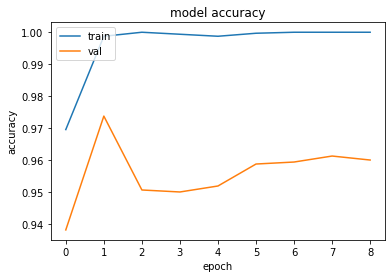

In [20]:
# summarize history for accuracy
acc_img = os.path.join(img_folder, '{}_{}_{}_resnet_201_batch32_acc.pdf'.format(seg_model, seg_nd, cluster_num))
plt.plot(model_history.history['accuracy'])
plt.plot(model_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.savefig(acc_img)
plt.show()

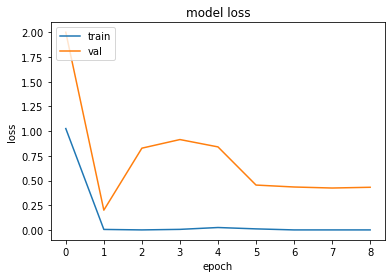

In [21]:
# summarize history for loss
loss_img = os.path.join(img_folder, '{}_{}_{}_resnet_201_batch32_loss.pdf'.format(seg_model, seg_nd, cluster_num))
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.savefig(loss_img)
plt.show()

In [22]:
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

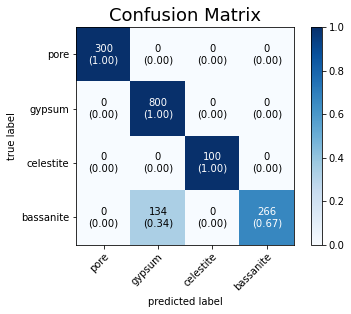

In [23]:
cm_img = os.path.join(img_folder, '{}_{}_{}_resnet_201_batch32_cm.pdf'.format(seg_model, seg_nd, cluster_num))
cm  = confusion_matrix(gold_label, predicted_class_indices, labels=[1,2,3,4])
class_name = ['pore', 'gypsum', 'celestite', 'bassanite']
fig, ax = plot_confusion_matrix(conf_mat=cm, colorbar=True, show_absolute=True, show_normed=True, cmap=plt.cm.Blues, class_names=class_name)
# plt.xlabel('Predictions', fontsize=16)
# plt.ylabel('Actuals', fontsize=16)
plt.title('Confusion Matrix', fontsize=18)
plt.savefig(cm_img)
plt.show()

# Test on results from other cluster num

### Prepare label

In [42]:
other_cluster_num = 64

In [43]:
# corresponding csv file to get slice & cluster combination
csv_file = os.path.join(os.getcwd(), 'seg_res_evaluation_csv', '{}_{}_{}.csv'.format(seg_model, seg_nd, other_cluster_num))
df = pd.read_csv(csv_file, usecols = ['slice', 'current_cluster'])
df['filename'] = df['slice'].map(str) + '\VA10_0050_0' + df['slice'].map(str) + '_' + df['current_cluster'].map(get_cluster_num_str)  + '.rec.8bit.png'

In [44]:
# prepare labels for data generator
cluster_label_one_slice = auto_label_last_201(seg_model, seg_nd, other_cluster_num, PRECISION_SOLO, threshold=0)
cluster_label = np.array(cluster_label_one_slice*401)
df['class'] = cluster_label
df['class'] = df['class'].map(str)

In [45]:
test_set = df.loc[df['slice'] < 500]
test_set.reset_index()

,index,slice,current_cluster,filename,class
0,0,400,0,400\VA10_0050_0400_000.rec.8bit.png,2
1,1,400,1,400\VA10_0050_0400_001.rec.8bit.png,4
2,2,400,2,400\VA10_0050_0400_002.rec.8bit.png,3
3,3,400,3,400\VA10_0050_0400_003.rec.8bit.png,1
4,4,400,4,400\VA10_0050_0400_004.rec.8bit.png,2
...,...,...,...,...,...
6395,6395,499,59,499\VA10_0050_0499_059.rec.8bit.png,4
6396,6396,499,60,499\VA10_0050_0499_060.rec.8bit.png,2
6397,6397,499,61,499\VA10_0050_0499_061.rec.8bit.png,1
6398,6398,499,62,499\VA10_0050_0499_062.rec.8bit.png,2


In [46]:
batch_size = 8

# Data path: used in data generator
base_folder = os.path.join(os.getcwd(), res_folder, seg_model, seg_nd, 'cluster_{}'.format(other_cluster_num))

other_test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
other_test_generator = other_test_datagen.flow_from_dataframe(dataframe=test_set, directory=base_folder,
                                             x_col='filename',
                                             y_col=None,
                                             target_size=(700, 855),
                                             batch_size=batch_size,
                                             shuffle=False,
                                             class_mode=None,
                                             seed=7
                                             )

Found 6400 validated image filenames.


### Load model

### Test

In [47]:
STEP_SIZE_TEST=other_test_generator.n//other_test_generator.batch_size

In [48]:
other_test_generator.reset()
pred=model.predict(other_test_generator,
                             steps=STEP_SIZE_TEST,
                             verbose=1)

800/800 [==============================] - 83s 103ms/step


## Stats for apply on cluster 128

In [40]:
predicted_class_indices = np.argmax(pred,axis=1) + 1 # because the class 0 is now used for those undecided pixels
# test_df = test_set.reset_index()
# test_df['vgg16_predict'] = pd.Series(predicted_class_indices)
#"""need to test the function below first"""
gold_label = test_set['class'].map(int)
gold_label = gold_label.to_numpy()
p, r, f1, _ = precision_recall_fscore_support(gold_label, predicted_class_indices, average=None, labels=[1,2,3,4])
acc = accuracy_score(gold_label, predicted_class_indices)
print("Test Accuracy: ", acc)
print(p, r, f1)
macro_p, macro_r, macro_f, _ = precision_recall_fscore_support(gold_label, predicted_class_indices, average='macro', labels=[1,2,3,4])
macro_p3, macro_r3, macro_f3, _ = precision_recall_fscore_support(gold_label, predicted_class_indices, average='macro', labels=[1,2,4])
micro_p, micro_r, micro_f, _ = precision_recall_fscore_support(gold_label, predicted_class_indices, average='micro', labels=[1,2,3,4])
micro_p3, micro_r3, micro_f3, _ = precision_recall_fscore_support(gold_label, predicted_class_indices, average='micro', labels=[1,2,4])
print("macro-averaged of 4 classes:")
print(macro_p, macro_r, macro_f)
print("macro-averaged of 3 classes:")
print(macro_p3, macro_r3, macro_f3)

Test Accuracy:  0.63140625
[0.37328543 0.94190791 0.13089005 0.61736859] [0.47625    0.7947541  1.         0.46121951] [0.41852801 0.86209656 0.23148148 0.52799107]
macro-averaged of 4 classes:
0.515862996778597 0.5100242793693425 0.5100242793693425
macro-averaged of 3 classes:
0.6441873115861224 0.6028718786652961 0.6028718786652961


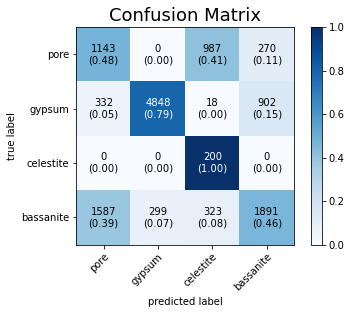

In [41]:
cm_img = os.path.join(img_folder, '{}_{}_{}_resnet_201_cm.pdf'.format(seg_model, seg_nd, other_cluster_num))
cm  = confusion_matrix(gold_label, predicted_class_indices, labels=[1,2,3,4])
class_name = ['pore', 'gypsum', 'celestite', 'bassanite']
fig, ax = plot_confusion_matrix(conf_mat=cm, colorbar=True, show_absolute=True, show_normed=True, cmap=plt.cm.Blues, class_names=class_name)
# plt.xlabel('Predictions', fontsize=16)
# plt.ylabel('Actuals', fontsize=16)
plt.title('Confusion Matrix', fontsize=18)
#plt.savefig(cm_img)
plt.show()

## Stats for apply on cluster 64

In [49]:
predicted_class_indices = np.argmax(pred,axis=1) + 1 # because the class 0 is now used for those undecided pixels
# test_df = test_set.reset_index()
# test_df['vgg16_predict'] = pd.Series(predicted_class_indices)
#"""need to test the function below first"""
gold_label = test_set['class'].map(int)
gold_label = gold_label.to_numpy()
p, r, f1, _ = precision_recall_fscore_support(gold_label, predicted_class_indices, average=None, labels=[1,2,3,4])
acc = accuracy_score(gold_label, predicted_class_indices)
print("Test Accuracy: ", acc)
print(p, r, f1)
macro_p, macro_r, macro_f, _ = precision_recall_fscore_support(gold_label, predicted_class_indices, average='macro', labels=[1,2,3,4])
macro_p3, macro_r3, macro_f3, _ = precision_recall_fscore_support(gold_label, predicted_class_indices, average='macro', labels=[1,2,4])
micro_p, micro_r, micro_f, _ = precision_recall_fscore_support(gold_label, predicted_class_indices, average='micro', labels=[1,2,3,4])
micro_p3, micro_r3, micro_f3, _ = precision_recall_fscore_support(gold_label, predicted_class_indices, average='micro', labels=[1,2,4])
print("macro-averaged of 4 classes:")
print(macro_p, macro_r, macro_f)
print("macro-averaged of 3 classes:")
print(macro_p3, macro_r3, macro_f3)

Test Accuracy:  0.7946875
[0.7169059  1.         0.23923445 0.6987782 ] [0.561875   0.89655172 1.         0.82611111] [0.62999299 0.94545455 0.38610039 0.75712831]
macro-averaged of 4 classes:
0.6637296365914787 0.6796690583546884 0.6796690583546884
macro-averaged of 3 classes:
0.8052280322017165 0.7775252824394557 0.7775252824394557


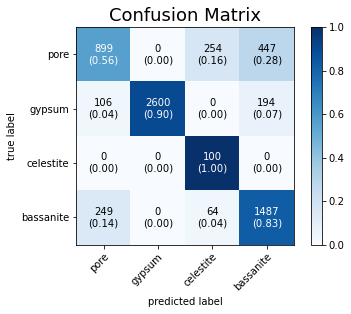

In [50]:
cm_img = os.path.join(img_folder, '{}_{}_{}_resnet_201_cm.pdf'.format(seg_model, seg_nd, other_cluster_num))
cm  = confusion_matrix(gold_label, predicted_class_indices, labels=[1,2,3,4])
class_name = ['pore', 'gypsum', 'celestite', 'bassanite']
fig, ax = plot_confusion_matrix(conf_mat=cm, colorbar=True, show_absolute=True, show_normed=True, cmap=plt.cm.Blues, class_names=class_name)
# plt.xlabel('Predictions', fontsize=16)
# plt.ylabel('Actuals', fontsize=16)
plt.title('Confusion Matrix', fontsize=18)
#plt.savefig(cm_img)
plt.show()

## Stats for apply on cluster 32

In [31]:
predicted_class_indices = np.argmax(pred,axis=1) + 1 # because the class 0 is now used for those undecided pixels
# test_df = test_set.reset_index()
# test_df['vgg16_predict'] = pd.Series(predicted_class_indices)
#"""need to test the function below first"""
gold_label = test_set['class'].map(int)
gold_label = gold_label.to_numpy()
p, r, f1, _ = precision_recall_fscore_support(gold_label, predicted_class_indices, average=None, labels=[1,2,3,4])
acc = accuracy_score(gold_label, predicted_class_indices)
print("Test Accuracy: ", acc)
print(p, r, f1)
macro_p, macro_r, macro_f, _ = precision_recall_fscore_support(gold_label, predicted_class_indices, average='macro', labels=[1,2,3,4])
macro_p3, macro_r3, macro_f3, _ = precision_recall_fscore_support(gold_label, predicted_class_indices, average='macro', labels=[1,2,4])
micro_p, micro_r, micro_f, _ = precision_recall_fscore_support(gold_label, predicted_class_indices, average='micro', labels=[1,2,3,4])
micro_p3, micro_r3, micro_f3, _ = precision_recall_fscore_support(gold_label, predicted_class_indices, average='micro', labels=[1,2,4])
print("macro-averaged of 4 classes:")
print(macro_p, macro_r, macro_f)
print("macro-averaged of 3 classes:")
print(macro_p3, macro_r3, macro_f3)

Test Accuracy:  0.8103125
[0.81355932 0.93589744 0.94339623 0.59920239] [0.61714286 0.9125     1.         0.75125   ] [0.7018684  0.92405063 0.97087379 0.66666667]
macro-averaged of 4 classes:
0.823013844291991 0.8158648714152218 0.8158648714152218
macro-averaged of 3 classes:
0.78288638358429 0.7641952330843734 0.7641952330843734


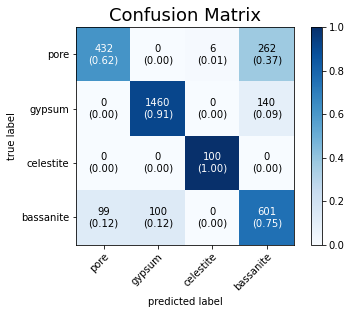

In [32]:
cm_img = os.path.join(img_folder, '{}_{}_{}_resnet_201_cm.pdf'.format(seg_model, seg_nd, other_cluster_num))
cm  = confusion_matrix(gold_label, predicted_class_indices, labels=[1,2,3,4])
class_name = ['pore', 'gypsum', 'celestite', 'bassanite']
fig, ax = plot_confusion_matrix(conf_mat=cm, colorbar=True, show_absolute=True, show_normed=True, cmap=plt.cm.Blues, class_names=class_name)
# plt.xlabel('Predictions', fontsize=16)
# plt.ylabel('Actuals', fontsize=16)
plt.title('Confusion Matrix', fontsize=18)
#plt.savefig(cm_img)
plt.show()

## Stats for apply on cluster 16

In [49]:
predicted_class_indices = np.argmax(pred,axis=1) + 1 # because the class 0 is now used for those undecided pixels
# test_df = test_set.reset_index()
# test_df['vgg16_predict'] = pd.Series(predicted_class_indices)
#"""need to test the function below first"""
gold_label = test_set['class'].map(int)
gold_label = gold_label.to_numpy()
p, r, f1, _ = precision_recall_fscore_support(gold_label, predicted_class_indices, average=None, labels=[1,2,3,4])
acc = accuracy_score(gold_label, predicted_class_indices)
print("Test Accuracy: ", acc)
print(p, r, f1)
macro_p, macro_r, macro_f, _ = precision_recall_fscore_support(gold_label, predicted_class_indices, average='macro', labels=[1,2,3,4])
macro_p3, macro_r3, macro_f3, _ = precision_recall_fscore_support(gold_label, predicted_class_indices, average='macro', labels=[1,2,4])
micro_p, micro_r, micro_f, _ = precision_recall_fscore_support(gold_label, predicted_class_indices, average='micro', labels=[1,2,3,4])
micro_p3, micro_r3, micro_f3, _ = precision_recall_fscore_support(gold_label, predicted_class_indices, average='micro', labels=[1,2,4])
print("macro-averaged of 4 classes:")
print(macro_p, macro_r, macro_f)
print("macro-averaged of 3 classes:")
print(macro_p3, macro_r3, macro_f3)

Test Accuracy:  0.734375
[1.         0.78309572 1.         0.49403341] [0.33    0.96125 1.      0.5175 ] [0.4962406  0.8630752  1.         0.50549451]
macro-averaged of 4 classes:
0.8192822839755213 0.7162025758516987 0.7162025758516987
macro-averaged of 3 classes:
0.759043045300695 0.6216034344689315 0.6216034344689315


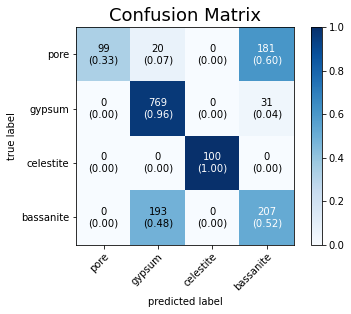

In [50]:
cm_img = os.path.join(img_folder, '{}_{}_{}_resnet_201_cm.pdf'.format(seg_model, seg_nd, other_cluster_num))
cm  = confusion_matrix(gold_label, predicted_class_indices, labels=[1,2,3,4])
class_name = ['pore', 'gypsum', 'celestite', 'bassanite']
fig, ax = plot_confusion_matrix(conf_mat=cm, colorbar=True, show_absolute=True, show_normed=True, cmap=plt.cm.Blues, class_names=class_name)
# plt.xlabel('Predictions', fontsize=16)
# plt.ylabel('Actuals', fontsize=16)
plt.title('Confusion Matrix', fontsize=18)
#plt.savefig(cm_img)
plt.show()